# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import csv
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy import ndimage
import random
from PIL import Image

import torch
import torch.nn as nn
import math
import copy
from torchvision import transforms, utils
from torchvision import models
from torch.utils.data import Dataset, DataLoader, Sampler
import torch.optim as optim

In [2]:
DATASET_PATH = "/kaggle/input/comma2k19-ld"
OUTPUT_PATH = "/kaggle/working"

# Data Visualization

In [3]:
# Code to Show steering angles with images
example_segment = os.path.join(DATASET_PATH, "scb1")
frame_times_path = f"{example_segment}/global_pose/frame_times"
steering_angle_path = f"{example_segment}/processed_log/CAN/steering_angle"

frame_times = np.load(frame_times_path)

print(frame_times.shape)
print(frame_times[:10])

(1200,)
[1736.474947 1736.524948 1736.574957 1736.624939 1736.674943 1736.724998
 1736.77494  1736.824954 1736.874956 1736.924936]


In [4]:
steering_angle = np.load(os.path.join(steering_angle_path, 'value'))

# Check number of samples
print(f"Number of samples: {len(steering_angle)}")
print(f"Steering angle: {steering_angle[0:41]}")  # Print every 4th element from the entire array

steering_angle_time = np.load(steering_angle_path + '/t')

print(f"Number of samples: {len(steering_angle_time)}")
print(f"Steering angle time: {steering_angle_time[0:41:4]}")  # Print every 4th element from the entire array

Number of samples: 6000
Steering angle: [-2.7 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8
 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8
 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8 -2.8]
Number of samples: 6000
Steering angle time: [1736.51122196 1736.55868367 1736.59777625 1736.6474123  1736.68076729
 1736.7138321  1736.7580062  1736.80215265 1736.84764665 1736.88085902
 1736.91373923]


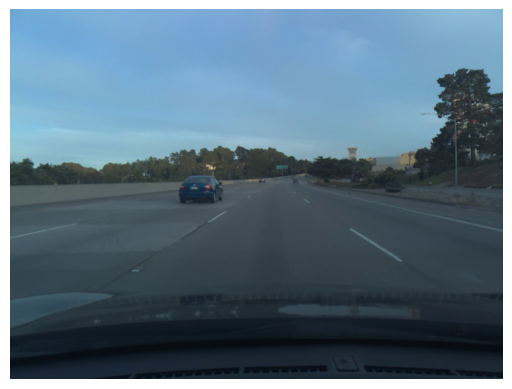

In [5]:
# Make sure the image is displayed correctly
img = cv2.imread(rf"{example_segment}/preview.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display

plt.imshow(img_rgb)
plt.axis('off')  # Hide axes
plt.show()

Total frames in scb1: 1200
Total frames in scb10: 1200
Total frames in scb100: 1200
Total frames in scb23: 1199
Example Image:


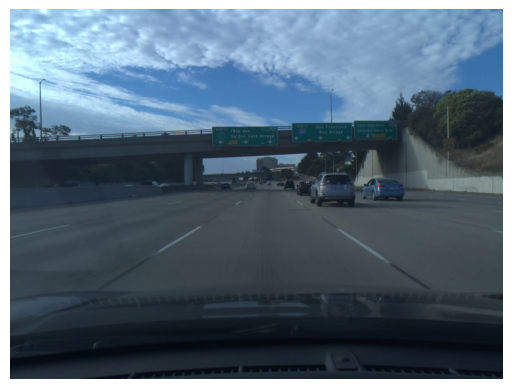

In [6]:
# Folder to save frames
# os.makedirs(rf"{example_segment}/frames", exist_ok=True)

example_segments = ['scb1', 'scb10', 'scb100', 'scb23']

for example in example_segments:
    vidpath = os.path.join(DATASET_PATH, example)
    # Convert video to frames
    vidcap = cv2.VideoCapture(rf"{vidpath}/video.hevc")
    success, image = vidcap.read()
    count = 0
    test_img = None
    while success:
        # cv2.imwrite(rf"{sample_folder}\frames\frame_{count}.png", image)  # save frame as PNG file
        success, image = vidcap.read()
        if count == 500:
            test_img = image
        count += 1
    
    print(f"Total frames in {example}: {count}")
print("Example Image:")
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axes
plt.show()


# Data Preprocessing

In [7]:
def print_array_info(main_folder: str, nested_folder: str):
    """
    Loop over NumPy arrays in the global_pose directory and print their information.

    Args:
        main_folder (str): Path to the main folder containing nested folders.
        nested_folder (str): Name of the current nested folder.

    Returns:
        None
    """
    file_paths = {
        "steering_angle": os.path.join(main_folder, nested_folder, "processed_log", "CAN", "steering_angle", "value"),
        "steering_angle Times": os.path.join(main_folder, nested_folder, "processed_log", "CAN", "steering_angle", "t"),
        "speed": os.path.join(main_folder, nested_folder, "processed_log", "CAN", "speed", "value"),
        "speed Times": os.path.join(main_folder, nested_folder, "processed_log", "CAN", "speed", "t")
    }
    global_pose_path = os.path.join(main_folder, nested_folder, "global_pose")

    for file_name in os.listdir(global_pose_path):
        file_path = os.path.join(global_pose_path, file_name)
        if os.path.isfile(file_path):  # Only add files
            file_paths[file_name] = file_path

    # Print information about each array in the dictionary
    for name, path in file_paths.items():
        try:
            # Load the NumPy array
            array = np.load(path)
            
            # Print the details
            print(f"Name: {name}")
            print(f"Length: {len(array)}")
            print(f"First 10 Samples: {array[:10]}")
            print("-" * 40)
        except Exception as e:
            print(f"Could not read {name} in {nested_folder}. Error: {e}")
    print("="* 100)


In [8]:
def process_video(main_folder: str, nested_folder: str, output_frames_dir: str, csv_file_path: str) -> None:
    """
    Process the video to extract frames and interpolate steering angles and speeds to match frame timestamps.
    Uses bulk interpolation for better efficiency.

    Args:
        main_folder (str): Path to the main folder containing the video and logs.
        nested_folder (str): Name of the nested folder to process.
        output_frames_dir (str): Path to the directory where frames will be saved.
        csv_file_path (str): Path to the CSV file where data will be logged.

    Returns:
        None
    """
    # Define paths
    nested_folder_path = os.path.join(main_folder, nested_folder, 'processed_log')
    video_file = os.path.join(main_folder, nested_folder, 'video.hevc')
    
    # Define paths for values and their timestamps
    steering_value_path = os.path.join(nested_folder_path, 'CAN', 'steering_angle', 'value')
    steering_time_path = os.path.join(nested_folder_path, 'CAN', 'steering_angle', 't')
    speed_value_path = os.path.join(nested_folder_path, 'CAN', 'speed', 'value')
    speed_time_path = os.path.join(nested_folder_path, 'CAN', 'speed', 't')
    frame_times_path = os.path.join(main_folder, nested_folder, 'global_pose', 'frame_times')

    # Check if required files exist
    required_files = [video_file, steering_value_path, steering_time_path, 
                     speed_value_path, speed_time_path, frame_times_path]
    
    if not all(os.path.isfile(f) for f in required_files):
        print(f"Missing required files in {nested_folder}")
        return

    try:
        # Load all data
        steering_angles = np.load(steering_value_path)
        steering_times = np.load(steering_time_path)
        speeds = np.load(speed_value_path).flatten()
        speed_times = np.load(speed_time_path)
        frame_times = np.load(frame_times_path)

        # Perform bulk interpolation
        interpolate_angle = interp1d(steering_times, steering_angles, 
                                   bounds_error=False, fill_value="extrapolate")
        interpolate_speed = interp1d(speed_times, speeds, 
                                   bounds_error=False, fill_value="extrapolate")
        
        interpolated_angles = interpolate_angle(frame_times)
        interpolated_speeds = interpolate_speed(frame_times)

        # Open video file
        cap = cv2.VideoCapture(video_file)
        if not cap.isOpened():
            print(f"Unable to open video file: {video_file}")
            return

        # Create output directory
        os.makedirs(output_frames_dir, exist_ok=True)
        output_dir_name = os.path.basename(output_frames_dir)

        # Process frames
        rows = []
        frame_idx = 0
        min_angle = np.min(interpolated_angles)
        max_angle = np.max(interpolated_angles)

        while cap.isOpened() and frame_idx < len(frame_times):
            ret, frame = cap.read()
            if not ret:
                break

            # Get pre-interpolated values for current frame
            timestamp = frame_times[frame_idx]
            angle = interpolated_angles[frame_idx]
            speed = interpolated_speeds[frame_idx]
            
            # Create relative path for frame
            frame_filename = f"{nested_folder}_{timestamp}.jpg"
            relative_frame_path = os.path.join(output_dir_name, frame_filename)
            absolute_frame_path = os.path.join(output_frames_dir, frame_filename)
            
            # Resize and save frame
            frame = cv2.resize(frame, (224, 224))
            cv2.imwrite(absolute_frame_path, frame)
            
            # Add to rows for CSV with relative path
            rows.append([
                timestamp,
                "center_camera",
                relative_frame_path,  # Store relative path in CSV
                angle,
                speed
            ])
                
            frame_idx += 1

        cap.release()

        # Write all data to the CSV
        with open(csv_file_path, 'a', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerows(rows)

        print(f"Processed {frame_idx} frames from {nested_folder}")
        print(f"Steering angle range: {min_angle:.2f} to {max_angle:.2f}")
        print(f"Original data lengths:")
        print(f"  Steering angles: {len(steering_angles)}")
        print(f"  Speeds: {len(speeds)}")
        print(f"  Frame times: {len(frame_times)}")
        print(f"  Interpolated values: {len(interpolated_angles)}")
        print("-------------------------------------------------------------")

        return min_angle, max_angle

    except Exception as e:
        print(f"Error processing {nested_folder}: {e}")
        return None, None

In [9]:
output_frames_dir = os.path.join(OUTPUT_PATH, "center_camera")
os.makedirs(output_frames_dir, exist_ok=True)

csv_file_path = os.path.join(OUTPUT_PATH, "interpolated.csv")
with open(csv_file_path, 'w', newline='') as f:
        csv_writer = csv.writer(f)
        csv_writer.writerow(['timestamp', 'frame_id', 'filename', 'angle', 'speed'])  # CSV header


# Variables to keep track of global min and max steering angles
global_min_angle = float('inf')
global_max_angle = float('-inf')
folders_processed = 0

for i, nested_folder in enumerate(os.listdir(DATASET_PATH)):
    # Break after processing 10 folders
    if i >= 20:
        break
    if not os.path.isdir(os.path.join(DATASET_PATH, nested_folder)):
        print(f"Skipping {nested_folder}, not a directory.")
        continue
    
    print(f"Processing folder {i + 1}: {nested_folder}")
    min_angle, max_angle = process_video(DATASET_PATH, nested_folder, output_frames_dir, csv_file_path)
    # print_array_info(DATASET_PATH, nested_folder)
    
    if min_angle is not None and max_angle is not None:
        global_min_angle = min(global_min_angle, min_angle)
        global_max_angle = max(global_max_angle, max_angle)
        print(f"Processed {nested_folder}: Min angle = {min_angle}, Max angle = {max_angle}")
    else:
        print(f"Skipping {nested_folder} due to missing files.")
    print("="*100)

print(f"Global Min Angle: {global_min_angle}, Global Max Angle: {global_max_angle}")

Processing folder 1: scb89
Processed 1200 frames from scb89
Steering angle range: -1.60 to 4.80
Original data lengths:
  Steering angles: 6000
  Speeds: 2994
  Frame times: 1200
  Interpolated values: 1200
-------------------------------------------------------------
Processed scb89: Min angle = -1.6, Max angle = 4.800000000000001
Processing folder 2: scb72
Processed 1200 frames from scb72
Steering angle range: -6.10 to 7.00
Original data lengths:
  Steering angles: 6000
  Speeds: 2993
  Frame times: 1200
  Interpolated values: 1200
-------------------------------------------------------------
Processed scb72: Min angle = -6.1000000000000005, Max angle = 7.0
Processing folder 3: scb68
Processed 1199 frames from scb68
Steering angle range: -5.60 to 3.50
Original data lengths:
  Steering angles: 6000
  Speeds: 2994
  Frame times: 1199
  Interpolated values: 1199
-------------------------------------------------------------
Processed scb68: Min angle = -5.6000000000000005, Max angle = 3.5

In [ ]:
import os

OUTPUT_PATH = "/kaggle/working"

def list_files_in_directory(directory):
    """Recursively list all files and directories in the specified directory."""
    for root, dirs, files in os.walk(directory):
        print(f"\nDirectory: {root}")
        for dir_name in dirs:
            print(f"  Subdirectory: {dir_name}")
        for file_name in files:
            print(f"  File: {file_name}")

# Print all contents in the Kaggle output directory
print(f"Contents of {OUTPUT_PATH}:")
list_files_in_directory(OUTPUT_PATH)

# Model Architecture Definition

## Motion Encoder

In [31]:
class TransformerMotionEncoderLayer(nn.Module):
    r"""TransformerEncoderLayer is made up of self-attn and feedforward network.
    This standard encoder layer is based on the paper "Attention Is All You Need".
    Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez,
    Lukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Advances in
    Neural Information Processing Systems, pages 6000-6010. Users may modify or implement
    in a different way during application.

    Args:
        d_model: the number of expected features in the input (required).
        nhead: the number of heads in the multiheadattention models (required).
        dim_feedforward: the dimension of the feedforward network model (default=2048).
        dropout: the dropout value (default=0.1).
        activation: the activation function of intermediate layer, relu or gelu (default=relu).

    Examples::
        >>> encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        >>> src = torch.rand(10, 32, 512)
        >>> out = encoder_layer(src)
    """
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.25, activation="relu"):
        super(TransformerMotionEncoderLayer, self).__init__()
        self.self_attn_frames = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.self_attn_motion = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear1_m = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.dropout_m = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.linear2_m = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm1_m = nn.LayerNorm(d_model)
        self.norm2_m = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout1_m = nn.Dropout(dropout)
        self.dropout2_m = nn.Dropout(dropout)
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        self.d_model = d_model
        


    def forward(self, frames_embeddings, motion_embeddings, src_mask=None, src_key_padding_mask=None):
        r"""Pass the input through the encoder layer.

        Args:
            src: the sequence to the encoder layer (required).
            src_mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """
        # skip connection for frames
        frame_attention = self.self_attn_frames(frames_embeddings, frames_embeddings, frames_embeddings, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        frames_embeddings = frames_embeddings + self.dropout1(frame_attention)
        src = self.norm1(frames_embeddings)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(frames_embeddings))))
        src = src + self.dropout2(src2)
        src_frames = self.norm2(src)
        
        # skip connection for motion
        motion_attention = self.self_attn_frames(frames_embeddings, frames_embeddings, motion_embeddings, attn_mask=src_mask,
                                                  key_padding_mask=src_key_padding_mask)[0]
        motion_embeddings = motion_embeddings + self.dropout1_m(motion_attention)
        src = self.norm1_m(motion_embeddings)
        src2 = self.linear2_m(self.dropout_m(self.activation(self.linear1_m(motion_embeddings))))
        src = src + self.dropout2_m(src2)
        src_motion = self.norm2_m(src)
        assert src_motion.shape == src_frames.shape
        
        return src_frames, src_motion

In [32]:
class TransformerMotionEncoder(nn.Module):
    r"""TransformerEncoder is a stack of N encoder layers

    Args:
        encoder_layer: an instance of the TransformerEncoderLayer() class (required).
        num_layers: the number of sub-encoder-layers in the encoder (required).
        norm: the layer normalization component (optional).

    Examples::
        >>> encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        >>> transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
        >>> src = torch.rand(10, 32, 512)
        >>> out = transformer_encoder(src)
    """
    __constants__ = ['norm']

    def __init__(self, encoder_layer,  num_layers, norm=None):
        super(TransformerMotionEncoder, self).__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm
        self.attention_linear = nn.Linear(encoder_layer.d_model * 2, encoder_layer.d_model)
    
    def forward(self, src, mask=None, src_key_padding_mask=None):
        r"""Pass the input through the encoder layers in turn.

        Args:
            src: the sequence to the encoder (required).
            mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """
        output = src

        for mod in self.layers:
            output = mod(*output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)
        x = torch.cat(output, dim=-1)
        output = self.attention_linear(x)
        if self.norm is not None:
            output = self.norm(output)

        return output
    
def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [33]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

## Motion Transformer

In [34]:
class MotionTransformer(nn.Module):
    def __init__(self, seq_len):
        self.seq_len = seq_len
        super(MotionTransformer,self).__init__()
        self.position_encoder = models.resnet18(pretrained=True)
        self.motion_encoder = models.resnet18(pretrained=True)
        self.d_model = 512
        self.position_embedder = nn.Linear(in_features =1000, out_features = self.d_model, bias=True)
        self.motion_embedder = nn.Linear(in_features =1000, out_features = self.d_model, bias=True)
        
        self.encoder_layer = TransformerMotionEncoderLayer(d_model=self.d_model, nhead=4, dropout=0.1)
        self.pos_encoder = PositionalEncoding(d_model=512)
        self.transformer_encoder = TransformerMotionEncoder(self.encoder_layer, num_layers=2, norm=None) #nn.LayerNorm(512)
        

        
        self.reduce_combined = nn.Linear(in_features =self.d_model, out_features = 64, bias=True)
        
        #self.reduce = nn.Linear(in_features = 128, out_features = 64, bias=True)
        self.steering_predictor = nn.Linear(in_features = 64, out_features = 1, bias=True)

        #self.motion_retrieval = nn.Linear(in_features = 128, out_features = 64, bias=True)
        self.speed_predictor = nn.Linear(in_features = 64, out_features = 1, bias=True)
    
    def generate_square_subsequent_mask(self,sz: int):
        """Generates an upper-triangular matrix of -inf, with zeros on diag."""
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
    
    def forward(self, frames, optical):
        frames = frames.reshape(-1, 3, 224, 224)
        optical = optical.reshape(-1, 3, 224, 224)
       # print(x.shape)
        frames = F.relu(self.position_embedder(self.position_encoder(frames)))
        frames = frames.reshape(-1,  self.seq_len, self.d_model).permute(1, 0, 2)


        optical = F.relu(self.motion_embedder(self.motion_encoder(optical)))
        optical = optical.reshape(-1,  self.seq_len, self.d_model).permute(1, 0, 2)
        

        #frames = self.pos_encoder(frames)
        attn_mask = self.generate_square_subsequent_mask(frames.shape[0]).cuda()
        fused_embedding = F.relu(self.transformer_encoder((frames, optical), mask=attn_mask))
        # LSTM 16
        #image = torch.tanh(self.LSTM2(image)[0])

        fused_embedding = fused_embedding.permute(1, 0, 2)
        fused_embedding = fused_embedding.reshape(-1, self.d_model)
        reduced = F.relu(self.reduce_combined(fused_embedding))
        #reduced = F.relu(self.reduce(reduced))
        #motion_information = F.relu(self.motion_retrieval(reduced))

        # FC 1
        speed = self.speed_predictor(reduced)
 
        # FC 16
        #steering_information = F.relu(self.steering_retrieval(reduced))

        # FC 1
        angle = self.steering_predictor(reduced)

        return angle, speed

# Dataset and Batch Samplers

## Aug Utils

In [35]:
def change_image_brightness_rgb(img, s_low=0.2, s_high=0.75):
    """
    Changes the image brightness by multiplying all RGB values by the same scalacar in [s_low, s_high).
    Returns the brightness adjusted image in RGB format.
    """
    img = img.astype(np.float32)
    s = np.random.uniform(s_low, s_high)
    img[:,:,:] *= s
    np.clip(img, 0, 255)
    return  img.astype(np.uint8)

def add_random_shadow(img, w_low=0.6, w_high=0.85):
    """
    Overlays supplied image with a random shadow polygon
    The weight range (i.e. darkness) of the shadow can be configured via the interval [w_low, w_high)
    """
    cols, rows = (img.shape[0], img.shape[1])
    
    top_y = np.random.random_sample() * rows
    bottom_y = np.random.random_sample() * rows
    bottom_y_right = bottom_y + np.random.random_sample() * (rows - bottom_y)
    top_y_right = top_y + np.random.random_sample() * (rows - top_y)
    if np.random.random_sample() <= 0.5:
        bottom_y_right = bottom_y - np.random.random_sample() * (bottom_y)
        top_y_right = top_y - np.random.random_sample() * (top_y)
    
    poly = np.asarray([[ [top_y,0], [bottom_y, cols], [bottom_y_right, cols], [top_y_right,0]]], dtype=np.int32)
        
    mask_weight = np.random.uniform(w_low, w_high)
    origin_weight = 1 - mask_weight
    
    mask = np.copy(img).astype(np.int32)
    cv2.fillPoly(mask, poly, (0, 0, 0))
    #masked_image = cv2.bitwise_and(img, mask)
    
    return cv2.addWeighted(img.astype(np.int32), origin_weight, mask, mask_weight, 0).astype(np.uint8)

def blur(image):
    return cv2.GaussianBlur(image, (3, 3), 0)

def translate_image(img, st_angle, translation_x, translation_y, delta_st_angle_per_px):
    """
    Shifts the image right, left, up or down. 
    When performing a lateral shift, a delta proportional to the pixel shifts is added to the current steering angle 
    """
    rows, cols = (img.shape[0], img.shape[1])
    #translation_x = np.random.randint(low_x_range, high_x_range) 
    #translation_y = np.random.randint(low_y_range, high_y_range) 
    
    st_angle += translation_x * delta_st_angle_per_px
    translation_matrix = np.float32([[1, 0, translation_x],[0, 1, translation_y]])
    img = cv2.warpAffine(img, translation_matrix, (cols, rows))
    
    return img, st_angle
def translate(image, steering_angle, x_translation, y_translation, x_translation_range, y_translation_range, steering_correction=0.065):
    #3image = Image.fromarray(np.uint8(image)).convert('RGB')
    steering_angle = steering_angle - (x_translation / x_translation_range * 2.0 * steering_correction)
    transformation_matrix = np.float32([[1, 0, x_translation],[0, 1, y_translation]])
    #transformed_img = image.transform(image.size, Image.AFFINE, transformation_matrix)
    transformed_img = cv2.warpAffine(image, transformation_matrix, (image.shape[0], image.shape[1]))
    return transformed_img, steering_angle

def do_rotate(image, angle, rotation_angle): #min=5, max=15, orientation='rand'):
    
    rows,cols,ch = image.shape
    
    #Randomly select a rotation angle from the range passed.

    rot_correct = 0.03
    M = cv2.getRotationMatrix2D((cols/2,rows/2), rotation_angle, 1)
    rshift = -rotation_angle
    angle += rot_correct * rshift
    return cv2.warpAffine(image, M, (cols, rows)), angle

def rotate_fn(img, rotate):
    return ndimage.rotate(img, rotate, reshape=False)

def apply_augs(image, angle, augs, optical=False):
    if not optical:
        if augs['random_brightness']:
            image = change_image_brightness_rgb(image)
        if augs['random_shadow']: 
            image = add_random_shadow(image)
        if augs['random_blur']:
            image = blur(image)
    
    if augs['rot'] is not None:
        image = rotate_fn(image, *augs['rot'])
    
    if augs['trans'] is not None:
        image, angle  = translate_image(image, angle, *augs['trans'])
    return image, angle

## Udacity Dataset

In [36]:
class UdacityDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, select_camera=None, slice_frames=None, select_ratio=1.0, select_range=None, optical_flow=True, seq_len=0, img_size=(224, 224)):
        
        assert select_ratio >= -1.0 and select_ratio <= 1.0 # positive: select to ratio from beginning, negative: select to ration counting from the end
        self.seq_len = seq_len
        camera_csv = pd.read_csv(csv_file)
        
        if select_camera:
            assert select_camera in ['left_camera', 'right_camera', 'center_camera'], "Invalid camera: {}".format(select_camera)
            camera_csv = camera_csv[camera_csv['frame_id']==select_camera]
        self.img_size = img_size
        csv_len = len(camera_csv)

        if slice_frames:
            csv_selected = camera_csv[0:0] # empty dataframe
            for start_idx in range(0, csv_len, slice_frames):
                if select_ratio > 0:
                    end_idx = int(start_idx + slice_frames * select_ratio)
                else:
                    start_idx, end_idx = int(start_idx + slice_frames * (1 + select_ratio)), start_idx + slice_frames

                if end_idx > csv_len:
                    end_idx = csv_len
                    
                if start_idx > csv_len:
                    start_idx = csv_len
                csv_selected = csv_selected.append(camera_csv[start_idx:end_idx])
            self.camera_csv = csv_selected
        
        elif select_range:
            csv_selected = camera_csv.iloc[select_range[0]: select_range[1]]
            self.camera_csv = csv_selected
        
        else:
            self.camera_csv = camera_csv
            
        self.root_dir = root_dir
        self.transform = transform
        self.optical_flow = optical_flow
        # Keep track of mean and cov value in each channel
        self.mean = {}
        self.std = {}
        for key in ['angle', 'speed']:
            self.mean[key] = np.mean(camera_csv[key])
            self.std[key] = np.std(camera_csv[key])

    def __len__(self):
        return len(self.camera_csv)
    
    def read_data_single(self, idx, augs):
        path = os.path.join(self.root_dir, self.camera_csv['filename'].iloc[idx])
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image[65:-25,:,:]
        original_img = image.copy()
        # angle independent augs

  
        augs['random_brightness'] = random.uniform(0, 1) > 0.5 
        augs['random_shadow'] = random.uniform(0, 1) > 0.5
        augs['random_blur'] = random.uniform(0, 1) > 0.5

        angle = self.camera_csv['angle'].iloc[idx]

        image, angle = apply_augs(image, angle, augs)
        angle_t = torch.tensor(angle)#.clamp(-1, 1)

  
        if self.transform:
            image_transformed = self.transform(cv2.resize(image, tuple(self.img_size)))

        if self.optical_flow:
            if idx != 0:
                path = os.path.join(self.root_dir, self.camera_csv['filename'].iloc[idx - 1])
                prev = cv2.imread(path)
                prev = cv2.cvtColor(prev, cv2.COLOR_BGR2RGB)
                prev = prev[65:-25,:,:]
                prev = cv2.cvtColor(prev, cv2.COLOR_RGB2GRAY)
            else:
                prev = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
            cur = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
            # Use Hue, Saturation, Value colour model
            flow = cv2.calcOpticalFlowFarneback(prev, cur, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            hsv = np.zeros(original_img.shape, dtype=np.uint8)
            hsv[..., 1] = 255
            
            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            hsv[..., 0] = ang * 180 / np.pi / 2
            hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
            optical_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
            optical_rgb, _ = apply_augs(optical_rgb, 0, augs, optical=True)
            optical_rgb = self.transform(cv2.resize(optical_rgb, tuple(self.img_size)))
            del original_img
            if augs['flip']:
                image_transformed = torch.fliplr(image_transformed)
                angle_t = angle_t * -1.0
                optical_rgb = torch.fliplr(optical_rgb)
            speed = self.camera_csv['speed'].iloc[idx]
            speed_t = torch.tensor(speed)
            return image_transformed, angle_t, optical_rgb, speed_t
        
        if self.transform:
            del image
            image = image_transformed
        if augs['flip']:
            image = torch.fliplr(image)
            angle_t = angle_t * -1.0
    
        return image, angle_t
    
    def read_data(self, idx, augs):
        """
        Parameters
        ----------
        idx : list or int
            DESCRIPTION.
            in case of list:
                if len(idx) == batch_size -> do not choose augmentations since it will be applied to the whole batch
                if len(idx) == sequence_length -> apply augmentations
            in case of int:
                apply augmentations
        augs: a dict of augmentations
        Returns
        -------
        image(s), angle(s), (optical_flow: optional)
        """
        if (isinstance(idx, int) and self.seq_len == 0) or (isinstance(idx, list) and len(idx) == self.seq_len):
            flip_horizontally = random.uniform(0, 1) > 0.5
            translate = None
            if random.uniform(0, 1) > 0.65: # translate
                translation_x = np.random.randint(-10, 10) 
                translation_y = np.random.randint(-10, 10)
                translate = (translation_x, translation_y, 0.35/100.0)
            rotate = None
            if random.uniform(0, 1) > 0.5: # rotate
                random_rot = random.uniform(-1, 1)#np.random.randint(5, 15+1)
                #rotation_angle = random.choice([-random_rot, random_rot])
                rotate = (random_rot,)
            augs = dict(
                flip=flip_horizontally,
                trans=translate,
                rot=rotate,
                )
        if isinstance(idx, list):
            data = None
            for i in idx:
                
                new_data = self.read_data(i, augs)
                if data is None:
                    data = [[] for _ in range(len(new_data))]
                for i, d in enumerate(new_data):
                    data[i].append(new_data[i])
                del new_data
            if self.optical_flow:
                for stack_idx in [0, 1, 2, 3]: # we don't stack timestamp and frame_id since those are string data
                    data[stack_idx] = torch.stack(data[stack_idx])
            else:
                for stack_idx in [0, 1]: # we don't stack timestamp and frame_id since those are string data
                    data[stack_idx] = torch.stack(data[stack_idx])

            return data
        
        else:
            return self.read_data_single(idx, augs)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        augs = dict(
            flip=False,
            trans=None,
            rot=None,
            )
        data = self.read_data(idx, augs)

        sample = {'image': data[0],
                  'angle': data[1]}
        if self.optical_flow:
            sample['optical'] = data[2]
            sample['speed'] = data[3]
        
        del data
        
        return sample

## Consecutive Batch Sampler

In [37]:
class ConsecutiveBatchSampler(Sampler):
    
    def __init__(self, data_source, batch_size, seq_len, drop_last=False, shuffle=True, use_all_frames=False):
        r""" Sampler to generate consecutive Batches
        
        Args:
            data_source: Source of data
            batch_size: Size of batch
            seq_len: Number of frames in each sequence (used for context for prediction)
            drop: Wether to drop the last incomplete batch
            shuffle: Wether to shuffle the data
        Return:
            List of iterators, size: [batch_size x seq_len x n_channels x height x width]
        """
        super(ConsecutiveBatchSampler, self).__init__(data_source)
        
        self.data_source = data_source
        
        assert seq_len >= 1, "Invalid batch size: {}".format(seq_len)
        self.seq_len = seq_len
        self.drop_last = drop_last
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.use_all_frames_ = use_all_frames
    
    def __iter__(self):
        
        data_size = len(self.data_source)
        
        if self.use_all_frames_:
            start_indices = list(range(data_size))
        else:
            start_indices = list(range(1, data_size, self.seq_len))
            
        if self.shuffle:
            random.shuffle(start_indices)
        
        batch = []
        for idx, ind in enumerate(start_indices):
            if data_size - idx < self.batch_size and self.drop_last: # if last batch
                break
                
            seq = []
            if ind + 1 < self.seq_len:
                seq.extend([0]*(self.seq_len - ind - 1) + list(range(0, ind+1)))
            else:
                seq.extend(list(range(ind-self.seq_len+1, ind+1)))
            
            batch.append(seq)
            
            if len(batch) == self.batch_size or idx == data_size - 1:
               # print(batch)
                yield batch
                batch = []

    
    def __len__(self):
        length = len(self.data_source)
        batch_size = self.batch_size
        
        if length % batch_size == 0 or self.drop_last:
            return length // batch_size
        
        return length // batch_size + 1

# Training Loop

In [38]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [25]:
!pip install easydict

In [39]:
from easydict import EasyDict as edict
parameters = edict(
    learning_rate = 0.0001,
    batch_size = 13,
    seq_len = 5,
    num_workers = 8,
    model_name = 'MotionTransformer',
    normalization = ([0.485, 0.456, 0.406],
                    [0.229, 0.224, 0.225]),
    image_size=(224, 224),
    epochs=10,
    all_frames=False,
    optical_flow=True
)
if not os.path.exists( f'saved_models/{parameters.model_name}'):
    os.makedirs(f'saved_models/{parameters.model_name}')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
network = MotionTransformer(parameters.seq_len) 
network.to(device)
optimizer = optim.Adam(network.parameters(),lr = parameters.learning_rate,betas=(0.9, 0.999), eps=1e-08)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
udacity_dataset = UdacityDataset(csv_file='/kaggle/working/interpolated.csv',
                             root_dir='/kaggle/working/',
                             transform=transforms.Compose([transforms.ToTensor()]),
                             select_camera='center_camera')

dataset_size = int(len(udacity_dataset))
del udacity_dataset
split_point = int(dataset_size * 0.9)

training_set = UdacityDataset(csv_file='/kaggle/working/interpolated.csv',
                             root_dir='/kaggle/working/',
                             transform=transforms.Compose([
                                 #transforms.Resize((224,224)),#(120,320)
                                 transforms.ToTensor(),
                                 transforms.Normalize(*parameters.normalization)
                                 ]),
                             img_size=parameters.image_size,
                             seq_len=parameters.seq_len,
                             optical_flow=parameters.optical_flow,
                             select_camera='center_camera',
                             select_range=(0,split_point))

validation_set = UdacityDataset(csv_file='/kaggle/working/interpolated.csv',
                             root_dir='/kaggle/working/',
                             transform=transforms.Compose([
                                # transforms.Resize((224,224)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(*parameters.normalization)
                                 ]),
                             img_size=parameters.image_size,
                             seq_len=parameters.seq_len,
                             optical_flow=parameters.optical_flow,
                             select_camera='center_camera',
                             select_range=(split_point,dataset_size))


training_cbs = ConsecutiveBatchSampler(data_source=training_set, batch_size=parameters.batch_size,use_all_frames=parameters.all_frames, shuffle=True, drop_last=False, seq_len=parameters.seq_len)
training_loader = DataLoader(training_set, sampler=training_cbs, num_workers=parameters.num_workers, collate_fn=(lambda x: x[0]))

validation_cbs = ConsecutiveBatchSampler(data_source=validation_set, batch_size=parameters.batch_size, use_all_frames=False, shuffle=False, drop_last=False, seq_len=parameters.seq_len)
validation_loader = DataLoader(validation_set, sampler=validation_cbs, num_workers=parameters.num_workers, collate_fn=(lambda x: x[0]))

/opt/conda/lib/python3.10/site-packages/torch/utils/data/sampler.py:65: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [41]:
criterion = torch.nn.MSELoss()
criterion.to(device)

speed_criterion =  torch.nn.SmoothL1Loss()
speed_criterion.to(device)

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = parameters.learning_rate
    if epoch in [30, 90, 150]:
        lr = parameters.learning_rate * 0.1
        parameters.learning_rate = lr

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

for epoch in range(parameters.epochs):
    train_angle_losses = AverageMeter()
    train_speed_losses = AverageMeter()
    torch.save(network.state_dict(), f'saved_models/{parameters.model_name}/epoch.tar')
    network.train()
    adjust_learning_rate(optimizer, epoch)
    # Calculation on Training Loss
    for training_sample in tqdm(training_loader):
        param_values = [v for v in training_sample.values()]
        if parameters.optical_flow:
            image, angle, optical, speed = param_values
            optical = optical.to(device)
            speed = speed.float().reshape(-1, 1).to(device)
        else:
            image, angle = param_values
        cur_bn = image.shape[0]
        loss = 0
        image = image.to(device)
        if parameters.optical_flow:
            angle_hat, speed_hat = network(image, optical)  
            speed_hat = speed_hat.reshape(-1, 1)
            training_loss_speed = speed_criterion(speed_hat,speed)
            loss += training_loss_speed
            train_speed_losses.update(training_loss_speed.item())
        else:
            angle_hat = network(image)

        angle_hat = angle_hat.reshape(-1, 1)
        angle = angle.float().reshape(-1, 1).to(device)
        training_loss_angle = torch.sqrt(criterion(angle_hat,angle) + 1e-6)
        loss += training_loss_angle

        train_angle_losses.update(training_loss_angle.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    print("Done")
    report = {}
    if split_point != dataset_size:
        network.eval()
        val_speed_losses = AverageMeter()
        val_angle_losses = AverageMeter()
        with torch.no_grad():    
            for Validation_sample in tqdm(validation_loader):
                param_values = [v for v in Validation_sample.values()]
                if parameters.optical_flow:
                    image, angle, optical, speed = param_values
                    optical = optical.to(device)
                    speed = speed.float().reshape(-1, 1).to(device)
                else:
                    image, angle = param_values
                cur_bn = image.shape[0]
                loss = 0
                image = image.to(device)
                #optical = optical.to(device)
                if parameters.optical_flow:
                    angle_hat, speed_hat = network(image, optical)  
                    speed_hat = speed_hat.reshape(-1, 1)
                    validation_loss_speed = speed_criterion(speed_hat,speed)
                    loss += validation_loss_speed
                    val_speed_losses.update(validation_loss_speed.item())
                else:
                    angle_hat = network(image)
                angle_hat = angle_hat.reshape(-1, 1)
                angle = angle.float().reshape(-1, 1).to(device)
    
                validation_loss_angle = torch.sqrt(criterion(angle_hat,angle) + 1e-6)
                loss += validation_loss_angle
    
                val_angle_losses.update(validation_loss_angle.item())
        report['val_loss'] = val_angle_losses.avg
    report['training_loss'] = train_angle_losses.avg
    if parameters.optical_flow:
        report['training_speed_loss'] = train_speed_losses.avg
        if split_point != dataset_size:
            report['validation_speed_loss'] = val_speed_losses.avg
            print(report)

TypeError: 'module' object is not callable

# Validation